In [ ]:
#| default_exp DDPM

# Denoising Diffusion Probabilistic Models(DDPM)

> In this notebook, I will illustrate the implementation of various components of [Denoising Diffusion Probabilistic Models](https://hojonathanho.github.io/diffusion/) using the MNIST dataset. Additionally, I will showcase the generation of images from the MNIST dataset.

![Generated output on MNIST](https://github.com/akansh12/Troj_diffusion_seminar/blob/main/nbs/images/output_benign.gif?raw=1)

## What is diffusion?
![Ink drop in a water](https://github.com/akansh12/Troj_diffusion_seminar/blob/main/nbs/images/ink_drop.jpg?raw=1)

Diffusion process : A diffusion process is stochastic markov process having continuous sample path. A process of moving from **Complex Distribution** to **Simple Distribution**. It has following properties:



- Stochastic
- Markov Chain
- Continuous sample path.

## What is DDPM?
Denoising Diffusion Probabilistic Models, DDPM in short, a paper by Jonathan Ho et al, defines a new class of generative models. Diffusion Models belong to the category of generative models, which are utilized to produce data resembling the training dataset. In essence, Diffusion Models operate by perturbing training data with incremental Gaussian noise and subsequently learning to reconstruct the original data by reversing this noise-induced degradation. Post-training, the Diffusion Model can be employed to generate data by feeding randomly sampled noise through the acquired denoising mechanism.

We can devide DDPM into two main components:

- Forward/diffusion Process
- Reverse/Sampling Process

## What is forward/diffusion process?

As stated previously, a Diffusion Model involves a forward process, also known as a diffusion process, where a data point, typically an image, undergoes incremental noise addition. We perform this by using a Linear Noise Scheduler.

Considering a data point sampled from a genuine data distribution as $\mathbf{x}_0 \sim q(\mathbf{x})$, we introduce the concept of a "forward diffusion process." In this process, Gaussian noise is incrementally added to the initial sample over $T$ steps, resulting in a series of noisy samples denoted as $\mathbf{x}_1, \dots, \mathbf{x}T$. The magnitude of each step is determined by a variance schedule denoted as ${\beta_t \in (0, 1)}{t=1}^T$
$$
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
$$

A nice property of the above diffusion process is that we can sample $\mathbf{x}_t$ from $\mathbf{x}_0$ using the equation:

\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}

where:
$\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/akansh12/Troj_diffusion_seminar/blob/main/nbs/01_DDPM.ipynb)


In [ ]:
#| notest
#| hide
!git clone https://github.com/akansh12/Troj_diffusion_seminar.git
%cd /content/Troj_diffusion_seminar/nbs/

In [2]:
#| notest
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import sys
sys.path.append('../')
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from models import Unet
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Noise Scheduler

We will start by implementing the basic building block of DDPM with Noise Scheduler. It takes in num of timesteps, beta_start and beta_end as input. It returns a noised image at timestep t.
Our Noise Scheduler class will have three components:


- __init__(): This will pre-compute and store all the coefficient related to $\alpha_{t}$ and others.
- __add_noise__(): This corresponds to forward process.
- __sample_prev_timestep__(): This is for reverse process and we will discuss it in later stage of this notebook.

In [3]:
#| notest
class LinearNoiseScheduler():
    def __init__(self, num_timesteps, beta_start, beta_end):
        pass
    def add_noise(self, original, noise, t):
        pass
    def sample_prev_timestep(self, xt, t, noise_pred):
        pass

Add Noise and Init function

In [4]:
#| notest
class LinearNoiseScheduler():
    '''Inspired from: https://github.com/explainingai-code/DDPM-Pytorch'''
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)

    def sample_prev_timestep(self, xt, t, noise_pred):
        pass

We can look at the values of alphas, betas and other for better understanding. As we have implemented linear scheduler, the value of $\alpha$ decrease with time which when looked in perspective of forward equation as mentioned earlier means that original image is decaying. While increasing value of $\beta$ show increase in gaussian noise component.

Text(0.5, 1.0, 'Sqrt One Minus Alpha Cum Prod')

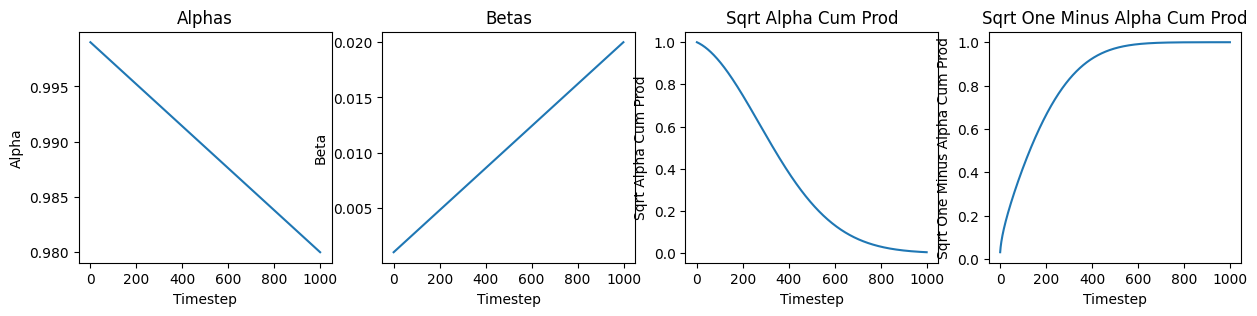

In [5]:
#| notest
linear_scheduler = LinearNoiseScheduler(1000, 0.001, 0.02)

plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(linear_scheduler.alphas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Alpha')
plt.title('Alphas')

plt.subplot(1,4,2)
plt.plot(linear_scheduler.betas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Beta')
plt.title('Betas')

plt.subplot(1,4,3)
plt.plot(linear_scheduler.sqrt_alphas_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt Alpha Cum Prod')
plt.title('Sqrt Alpha Cum Prod')

plt.subplot(1,4,4)
plt.plot(linear_scheduler.sqrt_one_minus_alpha_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt One Minus Alpha Cum Prod')
plt.title('Sqrt One Minus Alpha Cum Prod')

Deffusion process on 2D image.

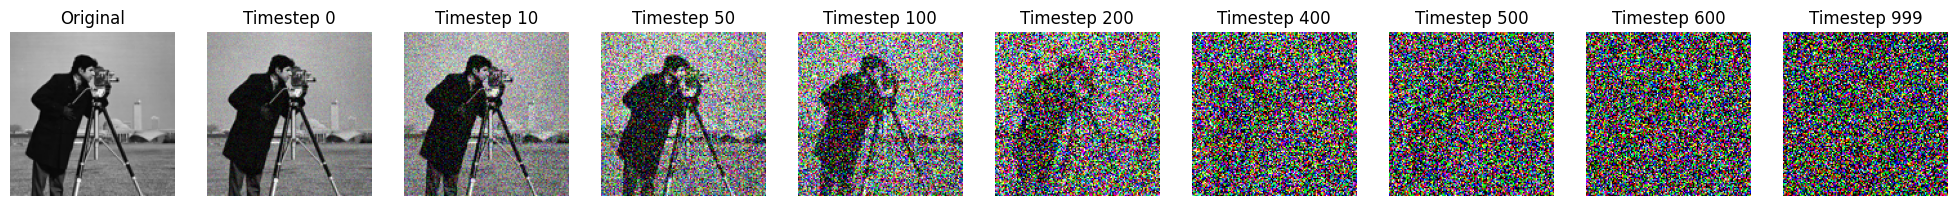

In [6]:
#| notest
test_img = Image.open("./images/cameraman.jpg")
test_img = test_img.resize((128, 128))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)
test_img = test_img.to(device)
step = [0, 10, 50, 100, 200, 400, 500, 600,999]
plt.figure(figsize=(25,15))
plt.subplot(1,10,1)
plt.imshow(np.transpose(test_img[0].cpu().numpy(), (1,2,0)))
plt.title('Original')
plt.axis('off');
for i, j in enumerate(step):
    plt.subplot(1,10,i+2)
    noise = torch.randn_like(test_img)
    test_img_noisy = linear_scheduler.add_noise(test_img, noise, j)
    plt.imshow(np.transpose(torch.clamp(test_img_noisy[0], 0, 1).cpu().numpy(), (1,2,0)))
    plt.axis('off');
    plt.title(f'Timestep {j}')

## What is Reverse diffusion process?

The magic of DDPM lies in the reverse process. In reverse process, we transform noise back into a sample from the target distribution.

If we are able to invert the aforementioned process and sample from $q(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$, we can reconstruct the original sample from a Gaussian noise input, denoted as $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. It's important to note that when $\beta_t$ is sufficiently small, $q(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$ also approximates a Gaussian distribution. However, estimating $q(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$ directly is challenging since it requires leveraging the entire dataset. Therefore, to perform the reverse diffusion process, we need to train a model $p_\theta$ to approximate these conditional probabilities.

The equations governing this process are as follows:

\begin{align*}
p_\theta(\mathbf{x}_{0:T}) &= p(\mathbf{x}_T) \prod^T_{t=1} p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) \\
p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t) &= \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}_\theta(\mathbf{x}_t, t), \boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t))
\end{align*}


For better understanding the equations, I highly recommend reading the blog by Lilian Weng:  [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) The forward and reverse process eqautions can be summarized by the following image.


![Forward and Sampling equations](https://github.com/akansh12/Troj_diffusion_seminar/blob/main/nbs/images/ddpm_for_reveerse.jpg?raw=1)


Now we know the reverse sampling process, we can modify our LinearNoiseScheduler to accomodate the reverse process.  

In [7]:
#| notest
class LinearNoiseScheduler():
    '''Inspired from: https://github.com/explainingai-code/DDPM-Pytorch'''
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)

    def sample_prev_timestep(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:

            return mean, mean
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0

## DDPM Training

<img src="https://github.com/akansh12/Troj_diffusion_seminar/blob/main/nbs/images/DDPM-algo.png?raw=1" style="width: 100%;" class="center" />
<figcaption>The training and sampling algorithms in DDPM (Image source: <a href="https://arxiv.org/abs/2006.11239" target="_blank">Ho et al. 2020</a>)</figcaption>


## Data preparation, Dataset and Dataloder

For setting up the dataset:
* Download the csv files for [Mnist](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)
and save them under ```data/MNIST_data```directory.

Verify the data directory has the following structure:
```
data/MNIST_data/train/images/{0/1/.../9}
	*.png
data/MNIST_data/test/images/{0/1/.../9}
	*.png
```

You can also run the following hidden cell(in Google Colab or local) to create the dataset as specified.

In [ ]:
#| notest
#| hide
import os
os.makedirs("/content/Troj_diffusion_seminar/data/", exist_ok = True)
!gdown 1xDw-9aud5o2-W9nwu43Wk3VVvHpvjlK2 -O /content/Troj_diffusion_seminar/data/
!gdown 1Ly6kZjHEQyWezvit4NG8RsNGRAB1OtAk -O /content/Troj_diffusion_seminar/data/
!unzip /content/Troj_diffusion_seminar/data/mnist_test.csv.zip -d /content/Troj_diffusion_seminar/data/
!unzip /content/Troj_diffusion_seminar/data/mnist_train.csv.zip -d /content/Troj_diffusion_seminar/data/

In [ ]:
#| notest
#| hide
# Code Snipet inspired from: https://github.com/explainingai-code/VAE-Pytorch/blob/main/utils/extract_mnist_images.py
import cv2
from tqdm import tqdm
import numpy as np
import _csv as csv
import os

def custom_extract_images(target_directory, data_file):
    os.makedirs(target_directory, exist_ok = True)
    assert os.path.exists(data_file), "The data file {} does not exist".format(data_file)
    with open(data_file) as file:
        reader = csv.reader(file)
        for index, row in enumerate(reader):
            if index == 0:
                continue
            image_array = np.zeros((784))
            image_array[:] = list(map(int, row[1:]))
            image_array = image_array.reshape((28,28))
            if not os.path.exists(os.path.join(target_directory, row[0])):
                os.mkdir(os.path.join(target_directory, row[0]))
            cv2.imwrite(os.path.join(target_directory, row[0], '{}.png'.format(index)), image_array)
            if index % 1000 == 0:
                print('Completed creating {} images in {}'.format(index+1, target_directory))

custom_extract_images("/content/Troj_diffusion_seminar/data/MNIST_data/train/images/", "/content/Troj_diffusion_seminar/data/mnist_train.csv")
custom_extract_images("/content/Troj_diffusion_seminar/data/MNIST_data/test/images/", "/content/Troj_diffusion_seminar/data/mnist_test.csv")

In [ ]:
#| notest
from dataset import Image_Dataset
from torch.utils.data import DataLoader
mnist_data = Image_Dataset("../data/MNIST_data/train/images/", transform=None, im_ext = '*.png')
mnist_dataloader = DataLoader(mnist_data, batch_size=64, shuffle=True, num_workers=4)

Verifying the size of input data.

In [11]:
#| notest
for x,y in mnist_data:
    print(x.shape)
    print(y)
    break

torch.Size([1, 28, 28])
tensor(9)


## Unet Model
For generation of image, we need a model architecture that has encoder-decoder components. Here we have used UNet with attention layers for image generation process.

The code of Unet is inspired from [here](https://github.com/explainingai-code/DDPM-Pytorch/blob/main/models/unet_base.py).

In [12]:
#| notest
import yaml
config_path = "../config/default.yaml"
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

In [13]:
#| notest
model = Unet(config['model_params'])
model.to(device)
num_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
scheduler = LinearNoiseScheduler(1000, 0.0001, 0.02)
num_timesteps = 1000

## Training Loop

In [ ]:
#| notest
# Training loop
for epoch_idx in range(num_epochs):
    epoch_losses = []
    # Iterate through the data loader
    for images, _ in tqdm(mnist_dataloader):
        optimizer.zero_grad()
        images = images.float().to(device)

        # Generate random noise
        noise = torch.randn_like(images).to(device)

        # Randomly select time step
        timestep = torch.randint(0, num_timesteps, (images.shape[0],)).to(device)

        # Introduce noise to images based on time step
        noisy_images = scheduler.add_noise(images, noise, timestep)

        # Forward pass
        noise_prediction = model(noisy_images, timestep)

        # Calculate loss
        loss = criterion(noise_prediction, noise)
        epoch_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Print epoch information
    print('Epoch:{} | Mean Loss: {:.4f}'.format(
        epoch_idx + 1,
        np.mean(epoch_losses),
    ))

    # Save model weights
    torch.save(model.state_dict(), "../model_weights/ddpm_ckpt.pth")

print('Training Completed!')

## Inference and Sampling

\For downloading the trained weights, please use the this link and save them under ```/model_weights/```directory.

In [ ]:
#| notest
#| hide
os.makedirs("../model_weights/", exist_ok = True)
!gdown 1WUXCD1WLBf41u1o31p5KKbkDSxIWxvWV -O ../model_weights/

In [16]:
#| notest
model.load_state_dict(torch.load(f'../model_weights/ddpm_ckpt.pth'))
model.eval();

In [19]:
#| notest
def sampling_grid(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1):
    model.to(device)
    model.eval()
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        xt, x0 = scheduler.sample_prev_timestep(xt, t, noise_pred)
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid_img = make_grid(ims, nrow=10)
        out_ing = transforms.ToPILImage()(grid_img)
        os.makedirs("./images/sampling_out/ddpm_sample/", exist_ok = True)
        out_ing.save(f'./images/sampling_out/ddpm_sample/timestep_{t.cpu().numpy()}.png')
        out_ing.close()

def sampling(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1):
    model.to(device)
    model.eval()
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        xt, x0 = scheduler.sample_prev_timestep(xt, t, noise_pred)
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1)/2
        img = transforms.ToPILImage()(ims.squeeze(0))
        images.append(img)
    return images

In [ ]:
#| notest
scheduler = LinearNoiseScheduler(1000, 0.0001, 0.02)
with torch.no_grad():
    images = sampling_grid(model, scheduler, 1000, 100, 28, 1)

with torch.no_grad():
    img = sampling(model, scheduler, 1000, 1)

## Result

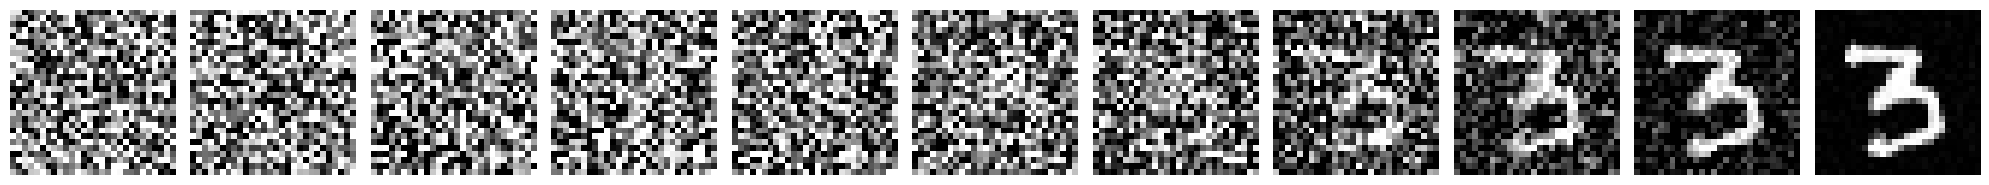

In [ ]:
#| notest
from PIL import Image
import matplotlib.pyplot as plt

selected_images = img[::99]

# Plot only 8 images from the selected_images list
num_images_to_plot = 11
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 5))

# Plot each selected image
for i, img_ in enumerate(selected_images[:num_images_to_plot]):
    axes[i].imshow(img_, cmap = 'gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
#| notest
import os
import imageio
image_dir = './images/sampling_out/ddpm_sample/'

image_files = sorted([os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')], reverse=True)

selected_images = []
for i, image_file in enumerate(image_files):
    if i % 25 == 0:
        selected_images.append(os.path.join(image_dir, f"timestep_[{i}].png"))

gif_images = []
for i in range(len(selected_images)-1, 0, -1):
    gif_images.append(imageio.imread(selected_images[i]))

output_gif_path = './images/output_benign.gif'

imageio.mimsave(output_gif_path, gif_images, duration=100)

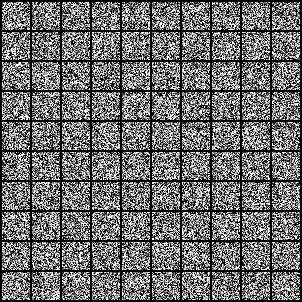

In [ ]:
#| notest
from IPython.display import Image
# Path to your GIF file
gif_path = './images/output_benign.gif'
# Display the GIF
Image(filename=gif_path)

![Generated output on MNIST](https://github.com/akansh12/Troj_diffusion_seminar/blob/main/nbs/images/output_benign.gif?raw=1)

## Refernces

-  [What are Diffusion Models? by Weng, Lilian](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/")
-  [Introduction to Diffusion Models for Machine Learning](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/)
-  The way of writing the code is inspired from: [https://github.com/explainingai-code](https://github.com/explainingai-code/DDPM-Pytorch )
-  [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)

Please check: Seminar presentation Link by me: [Presentation](https://docs.google.com/presentation/d/1CktLNGnoMf4NUnueRCSHKHaeX85XuKcVA4hMRti1xjc/edit?usp=sharing)

Author Details


- Name: Akansh Maurya
- Github: [https://akansh12.github.io/](https://akansh12.github.io/)
- Linkedin: [Akansh Maurya](https://www.linkedin.com/in/akansh-maurya/)
- Email: akanshmaurya@gmail.com